# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable whether the worker was enrolled in the training workshop

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1: (20 min)

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

**Answer.** One possible solution is shown below:

In [3]:
# let's have an overview of the data
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


The average income of the population in 1974 was around $\$4558$, which dropped to $\$2185$ in 1975. That is a drop of over $50\%$! This drop may be due to a plausible economic crisis during the 1970s. A quick search verifies this: [There was an economic recession that lasted from  1973 to 1975](https://en.wikipedia.org/wiki/1973%E2%80%931975_recession). Later, the average income in 1978 increased to $\$6793$, probably as the recession was over by that time. 

We can check the percentage of the population whose income decreased in 1975 as follows:

In [4]:
lalonde_df[lalonde_df['re74']>lalonde_df['re75']].describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,0.129825,29.235088,10.494737,0.235088,0.119298,0.575439,0.536842,9037.821982,2925.240138,7826.161313
std,0.336702,10.109828,2.598240,0.424800,0.324709,0.495146,0.499518,6972.591218,3464.763970,8005.875944
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.022400,0.000000,0.000000
25%,0.000000,21.000000,9.000000,0.000000,0.000000,0.000000,0.000000,3030.986000,42.967740,422.629800
50%,0.000000,26.000000,11.000000,0.000000,0.000000,1.000000,1.000000,8128.998000,1679.323000,5748.356000
75%,0.000000,36.000000,12.000000,0.000000,0.000000,1.000000,1.000000,13311.260000,4636.935000,13429.580000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,18347.230000,36646.950000


We see that 285 people had a lower income in 1975, which corresponds to $46.4\%$ of the population! 

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.** From the solution of Exercise 1.1, we see that the mean of the column `treat` was $0.30$. Thus, about $30\%$ of the workers in our dataset are in the treatment group. In addition, we notice that about $13\%$ of the workers whose salary decreased in $1975$ were in the treatment group.   
    
Finally, we can check the differences in median and mean as follows:

In [5]:
lalonde_df.groupby('treat')['re78'].agg(['median','mean'])

,median,mean
treat,,
0,4975.505,6984.169742
1,4232.309,6349.143530


In [6]:
6984.169742 - 6349.143530

635.0262119999998

In [7]:
scipy.stats.ttest_ind(lalonde_df.loc[lalonde_df['treat']==1, 're78'], lalonde_df.loc[lalonde_df['treat']==0, 're78'], axis=0, equal_var= False)

Ttest_indResult(statistic=-0.9377296979393183, pvalue=0.3490766555566698)

It seems that treatment "hurts" workers; we see a decrease of $635 dollars, although this does not seem to 
be statistically significant. 

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.** This is a naive conclusion. This measurement does not take into account the background of those who are selected for training program vs. those who don't enroll in the program. In the LaLonde study, those who were selected into training program were chosen specifically due to their low earning potential and therefore systematically differ from those in the control group who were not selected for job training. This source of bias needs to be accounted for when doing subsequent analysis.

Before we start our exploration on causality, let's perform some simple setup:

1. We separate the `treat` (treatment) indicator from our dataset. We will want to use this as our objective variable to fit models to later
2. We are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [8]:
#First, let's reset the indexes
cleaned_df=lalonde_df.reset_index().drop(['index'],axis=1)

#Create seperate structure for data and target 
treatment = cleaned_df['treat']
rev78 = cleaned_df['re78']
cleaned_df = cleaned_df.drop(['treat', 're78'], axis=1)

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2: (20 min)

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.** One possible solution is shown below:

In [9]:
# Define params and inputs
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
agg_operations = {'treat': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in covariates
})

In [10]:
def compute_table_one_smd(table_one, covariates, round_digits=4):
    feature_smds = []
    for feature in covariates:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'covariates': covariates, 'smd': feature_smds})

In [11]:
table_one_matched = lalonde_df.groupby('treat').agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched, covariates)
table_one_smd_matched

,covariates,smd
0,age,0.2419
1,educ,0.0448
2,black,1.6677
3,hispan,0.2769
4,married,0.7195
5,nodegree,0.2350
6,re74,0.5958
7,re75,0.2870


We see that all features, with the exception of `educ`, are considered seriously imbalanced.

#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.** One possible solution is shown below:

treat
0    AxesSubplot(0.125,0.657941;0.227941x0.222059)
1    AxesSubplot(0.125,0.657941;0.227941x0.222059)
Name: age, dtype: object

Text(0.5, 0, 'age')

treat
0    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
1    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
Name: black, dtype: object

Text(0.5, 0, 'black')

treat
0    AxesSubplot(0.672059,0.657941;0.227941x0.222059)
1    AxesSubplot(0.672059,0.657941;0.227941x0.222059)
Name: hispan, dtype: object

Text(0.5, 0, 'hispan')

treat
0    AxesSubplot(0.125,0.391471;0.227941x0.222059)
1    AxesSubplot(0.125,0.391471;0.227941x0.222059)
Name: married, dtype: object

Text(0.5, 0, 'married')

treat
0    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
1    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
Name: nodegree, dtype: object

Text(0.5, 0, 'nodegree')

treat
0    AxesSubplot(0.672059,0.391471;0.227941x0.222059)
1    AxesSubplot(0.672059,0.391471;0.227941x0.222059)
Name: re74, dtype: object

Text(0.5, 0, 're74')

treat
0    AxesSubplot(0.125,0.125;0.227941x0.222059)
1    AxesSubplot(0.125,0.125;0.227941x0.222059)
Name: re75, dtype: object

Text(0.5, 0, 're75')

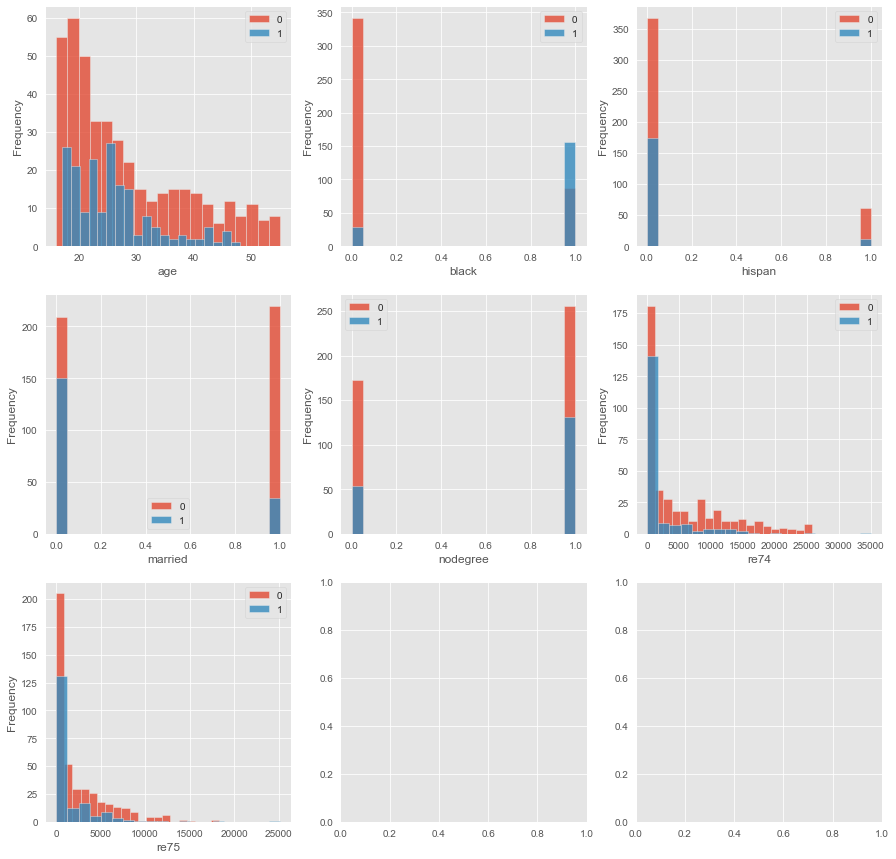

In [12]:
imbalanced=['age', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
fig, axes=plt.subplots(ncols=3,nrows=3, figsize=(15,15))
for index, feature in enumerate(imbalanced):
    if index<3:
        i=0 
        j=index
    elif index<6:
        i=1 
        j=index-3
    else:
        i=2 
        j=0

    lalonde_df.groupby('treat')[feature].plot(kind='hist', 
                                              bins=20, alpha=0.8, legend=True,
                                              ax=axes[i,j])
    axes[i,j].set_xlabel(feature);
    

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3: (20 min)

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.** One possible solution is shown below:

In [13]:
formula = 'treat ~ age + educ + black + hispan + married + nodegree + re74 + re75'
logit_model = smf.logit(formula=formula, data=lalonde_df).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.3508
Time:                        18:30:03   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.

A logistic regressor outputs values between $0$ and $1$. In this case, these values indicate the probability of an individual being part of the treatment group. Thus, we can use them as a propensity score.

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.** One possible solution is given below:

In [14]:
pscore_logit = logit_model.predict()

(0, 1)

Text(0.5, 1.0, 'Propensity Score Distribution Before Matching: Control vs Treatment')

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Scores')

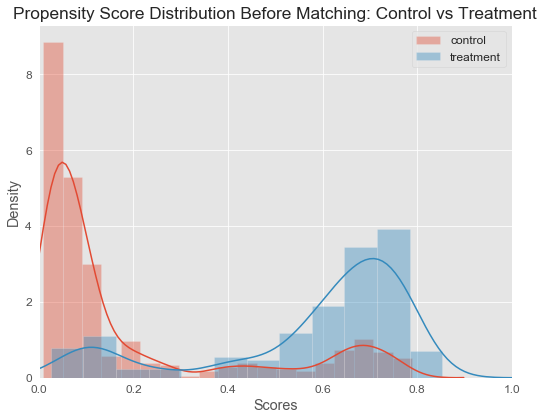

In [15]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(pscore_logit[treatment==0], label='control')
sns.distplot(pscore_logit[treatment==1], label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution Before Matching: Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4 (30 min):

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.** One possible solution is given below:

In [16]:
# we seperate the pscore based on it's 
# corresponding true label value
tags = treatment == 1
treat_pscores = pscore_logit[tags]
control_pscores = pscore_logit[~tags]

knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(control_pscores.reshape(-1, 1))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

**Answer.** One possible solution is given below:

In [17]:
distances, indices = knn.kneighbors(treat_pscores.reshape(-1, 1))

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.** One possible solution is given below:

In [18]:
#First, we extract the closest neighbors:
sim_indices=indices[:,0]

# Display matching table
mask = lalonde_df['treat'] == 1
df_treat = lalonde_df[mask]
df_control = lalonde_df[~mask].iloc[sim_indices]
df_matched_join = (df_treat.reset_index(drop=True)
              .merge(df_control.reset_index(drop=True), 
                     left_index=True, 
                     right_index=True))
df_matched_join

,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,re78_x,treat_y,age_y,educ_y,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y
0,1,37,11,1,0,1,1,0.0000,0.000,9930.0460,0,30,17,1,0,0,0,17827.37000,5546.41900,14421.13000
1,1,22,9,0,1,0,1,0.0000,0.000,3595.8940,0,51,11,0,0,0,1,48.98167,3813.38700,1525.01400
2,1,30,12,1,0,0,0,0.0000,0.000,24909.4500,0,16,9,1,0,0,1,0.00000,0.00000,2158.95900
3,1,27,11,1,0,0,1,0.0000,0.000,7506.1460,0,39,10,1,0,0,1,844.44400,889.79030,701.92010
4,1,33,8,1,0,0,1,0.0000,0.000,289.7899,0,19,9,1,0,0,1,1079.55600,2873.46800,14344.29000
5,1,22,9,1,0,0,1,0.0000,0.000,4056.4940,0,17,9,1,0,0,1,0.00000,981.09680,8900.34700
6,1,23,12,1,0,0,0,0.0000,0.000,0.0000,0,17,8,1,0,0,1,0.00000,451.16130,0.00000
7,1,32,11,1,0,0,1,0.0000,0.000,8472.1580,0,20,11,1,0,0,1,0.00000,3480.38700,5495.66500
8,1,22,16,1,0,0,0,0.0000,0.000,2164.0220,0,39,10,1,0,0,1,844.44400,889.79030,701.92010
9,1,33,12,0,0,1,0,0.0000,0.000,12418.0700,0,39,12,0,0,1,0,1289.19800,0.00000,1202.86900


### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5 (15 min):

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

**Answer.** One possible solution is given below:

(0, 1)

Text(0.5, 1.0, 'Propensity Score Distribution After Matching: Control vs Treatment')

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Scores')

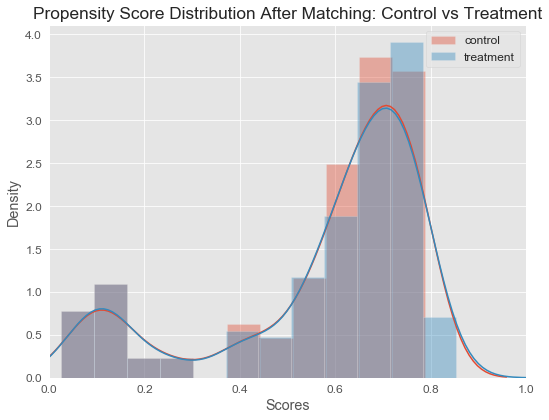

In [19]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(control_pscores[sim_indices], label='control')
sns.distplot(treat_pscores, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution After Matching: Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

We see that the distribution of propensity scores for control and treatment groups are much closer this time. 

### Exercise 6 (30 min):

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups **before matching**. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.** One possible solution is given below:

In [20]:
# Create matching table
mask = lalonde_df['treat'] == 1
df_treat = lalonde_df[mask]
df_control = lalonde_df[~mask].iloc[sim_indices]
df_matched = pd.concat([df_treat, df_control], axis=0) # this time we join by axis-0

# Calculate Rosenbaum ASMD
table_one_matched = df_matched.groupby('treat').agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched, covariates)

table_one_smd_matched

,covariates,smd
0,age,0.2036
1,educ,0.0139
2,black,0.0147
3,hispan,0.0223
4,married,0.1625
5,nodegree,0.0118
6,re74,0.0499
7,re75,0.0102


It seems that covariate balance is much better, as all but two of the variables have SMD less than 0.1, and all but one has SMD less than 0.2 (and the remaining one is right on the cusp).

If we look once again at the histograms of several covariates after we apply matching, we can see a marked improvement in the similarity of the histograms of the control and treatment groups:

treat
0    AxesSubplot(0.125,0.657941;0.227941x0.222059)
1    AxesSubplot(0.125,0.657941;0.227941x0.222059)
Name: age, dtype: object

Text(0.5, 0, 'age')

treat
0    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
1    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
Name: black, dtype: object

Text(0.5, 0, 'black')

treat
0    AxesSubplot(0.672059,0.657941;0.227941x0.222059)
1    AxesSubplot(0.672059,0.657941;0.227941x0.222059)
Name: hispan, dtype: object

Text(0.5, 0, 'hispan')

treat
0    AxesSubplot(0.125,0.391471;0.227941x0.222059)
1    AxesSubplot(0.125,0.391471;0.227941x0.222059)
Name: married, dtype: object

Text(0.5, 0, 'married')

treat
0    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
1    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
Name: nodegree, dtype: object

Text(0.5, 0, 'nodegree')

treat
0    AxesSubplot(0.672059,0.391471;0.227941x0.222059)
1    AxesSubplot(0.672059,0.391471;0.227941x0.222059)
Name: re74, dtype: object

Text(0.5, 0, 're74')

treat
0    AxesSubplot(0.125,0.125;0.227941x0.222059)
1    AxesSubplot(0.125,0.125;0.227941x0.222059)
Name: re75, dtype: object

Text(0.5, 0, 're75')

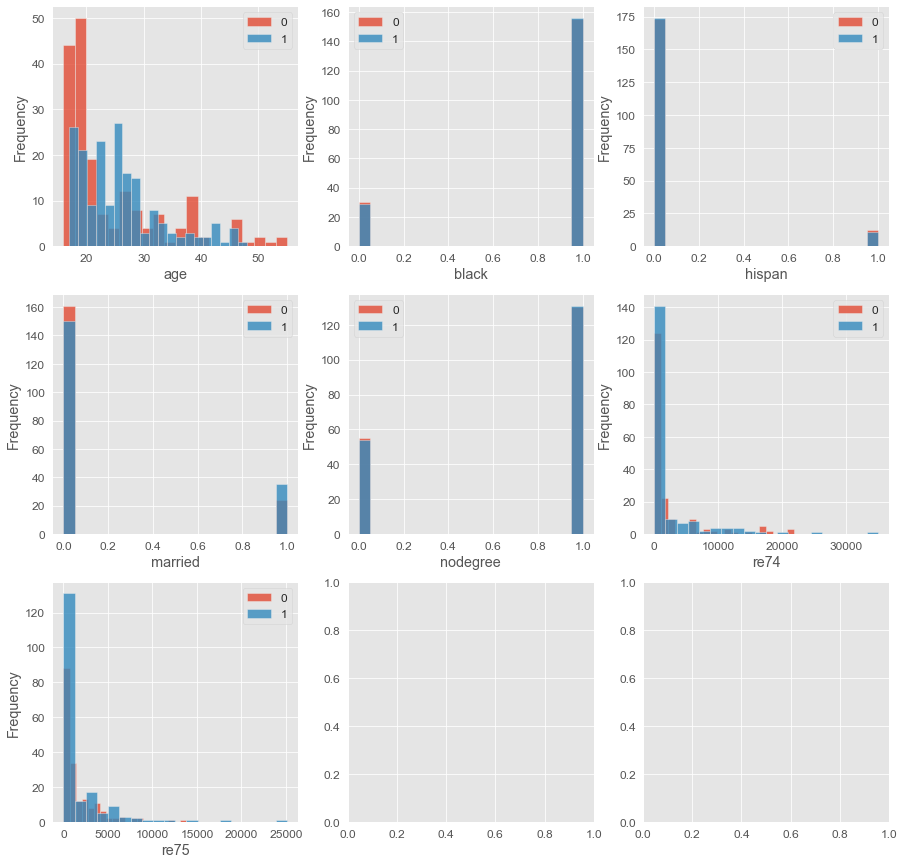

In [21]:
imbalanced=['age', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
fig, axes=plt.subplots(ncols=3,nrows=3, figsize=(15,15))
for index, feature in enumerate(imbalanced):
    if index<3:
        i=0 
        j=index
    elif index<6:
        i=1 
        j=index-3
    else:
        i=2 
        j=0

    df_matched.groupby('treat')[feature].plot(kind='hist', 
                                              bins=20, alpha=0.8, legend=True,
                                              ax=axes[i,j])
    axes[i,j].set_xlabel(feature);

### Exercise 7 (15 min):

Estimate the average effect of treatment on <font color='red'> wages (`re78`) </font> after matching. What do you conclude?

**Answer.** Shown below:

In [22]:
df_matched_join.head()

,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,re78_x,treat_y,age_y,educ_y,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,30,17,1,0,0,0,17827.37000,5546.4190,14421.1300
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,51,11,0,0,0,1,48.98167,3813.3870,1525.0140
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0,16,9,1,0,0,1,0.00000,0.0000,2158.9590
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,39,10,1,0,0,1,844.44400,889.7903,701.9201
4,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,19,9,1,0,0,1,1079.55600,2873.4680,14344.2900


In [23]:
df_matched_join["ATE"] = df_matched_join["re78_x"] - df_matched_join["re78_y"]

In [24]:
df_matched_join["ATE"].mean()

1774.4613708108106

It seems like there is indeed is a positive effect on wages after training.

## Propensity score matching using decision trees and random forests

### Exercise 8 (45 min):

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.** Shown below:

In [25]:
dt=tree.DecisionTreeRegressor(max_depth=4)
dt.fit(cleaned_df,treatment)
pscore_tree=dt.predict(cleaned_df)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated (less than 10 years of educ) Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.** Shown below:

[Text(4558.660714285715, 4892.4, 'black <= 0.5\nentropy = 0.211\nsamples = 614\nvalue = 0.301'),
 Text(2391.4285714285716, 3805.2, 're74 <= 16.654\nentropy = 0.072\nsamples = 371\nvalue = 0.078'),
 Text(1195.7142857142858, 2718.0, 'age <= 18.5\nentropy = 0.166\nsamples = 95\nvalue = 0.211'),
 Text(597.8571428571429, 1630.7999999999997, 'married <= 0.5\nentropy = 0.026\nsamples = 37\nvalue = 0.027'),
 Text(298.92857142857144, 543.5999999999995, 'entropy = 0.0\nsamples = 33\nvalue = 0.0'),
 Text(896.7857142857143, 543.5999999999995, 'entropy = 0.188\nsamples = 4\nvalue = 0.25'),
 Text(1793.5714285714287, 1630.7999999999997, 'married <= 0.5\nentropy = 0.22\nsamples = 58\nvalue = 0.328'),
 Text(1494.6428571428573, 543.5999999999995, 'entropy = 0.25\nsamples = 34\nvalue = 0.5'),
 Text(2092.5, 543.5999999999995, 'entropy = 0.076\nsamples = 24\nvalue = 0.083'),
 Text(3587.1428571428573, 2718.0, 'age <= 23.5\nentropy = 0.032\nsamples = 276\nvalue = 0.033'),
 Text(2989.2857142857147, 1630.79999

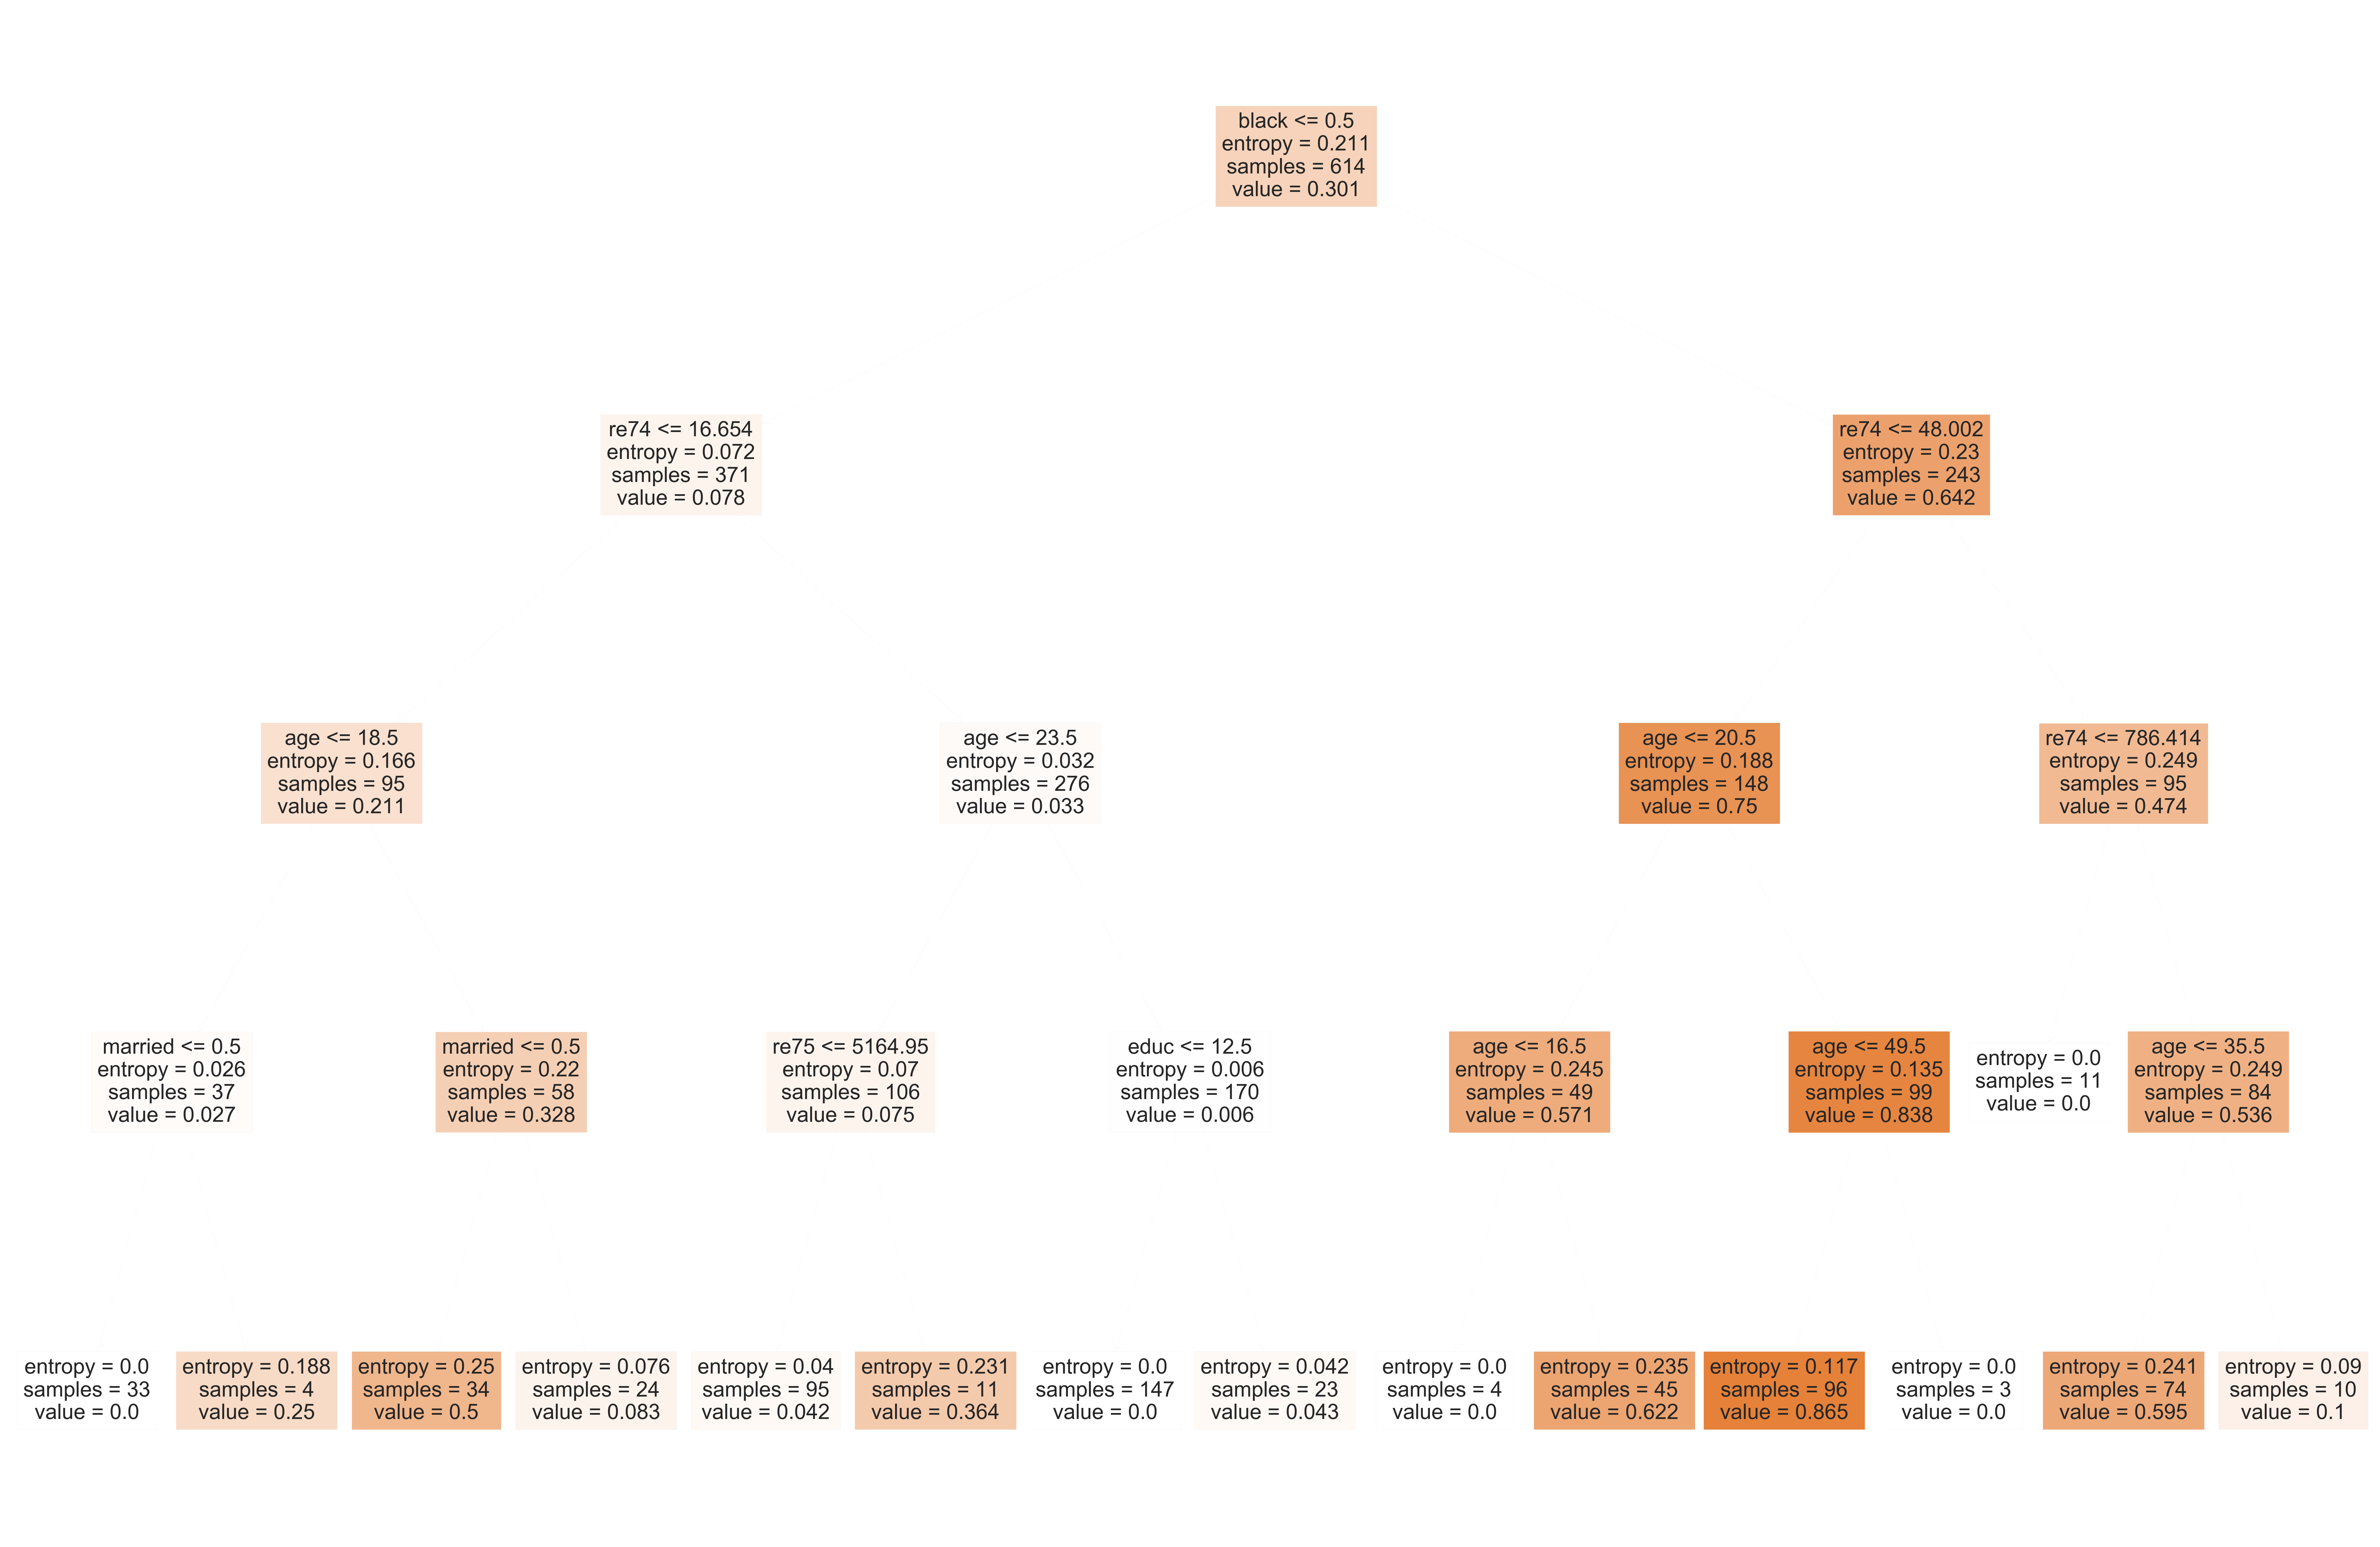

In [26]:
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')

If we follow the tree, we see that the probability that the Hispanic was enrolled in the program is $0.865$. In contrast, the black man would have had zero probability of being enrolled in the program. 

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.** One possible solution is shown below:

In [27]:
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(cleaned_df, treatment)
pscore_forest=rf.predict_proba(cleaned_df)[::,1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.** One possible solution is shown below:

Text(0.5, 1.0, 'ROC Curves')

Text(0.5, 1.0, 'ROC Curves')

Text(0.5, 1.0, 'ROC Curves')

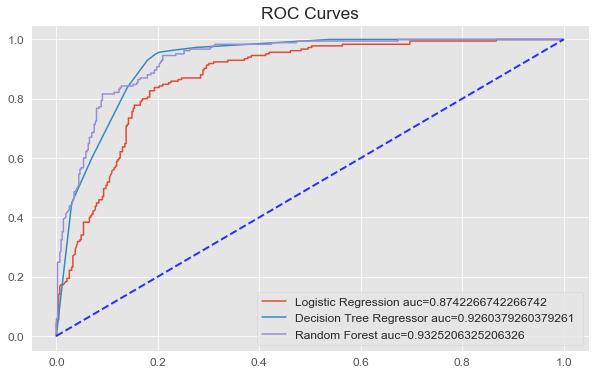

In [28]:
model_names={'Logistic Regression':pscore_logit, 'Decision Tree Regressor':pscore_tree, 'Random Forest':pscore_forest}

fig, ax = plt.subplots(figsize=(10, 6))
for name in model_names:

    fpr, tpr, _ = metrics.roc_curve(treatment, model_names[name])
    auc=metrics.auc(fpr, tpr)
    
    # Display plot for ROC curve
    ax.plot(fpr,tpr,label=name+" auc=%s " % str(auc))
    plt.legend(loc=4)
    plt.title("ROC Curves")
    
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b',
        label='Chance', alpha=.8)
plt.show()

We see that the AUC of the random forest is the highest, though not by much. Both the decision tree and random forest solidly outperformed the logistic regression model.

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.** The statement is false. Consider an artificial model that assigns a propensity score of $1$ to all the individuals in the treatment group and a propensity score of $0$ to individuals in the control group. Then, the AUC of this model is equal to one! However, any matching using this model will arbitrarily select 185 individuals from the control group, and the covariates will most certainly remain unbalanced. 

Thus, it is important to avoid overfitting in our models. We can do this by splitting the treatment/control groups with train/test test, build our models using the train set and evaluate their performance by comparing the AUCs on the train and the test sets.

Remember that these models only give an estimation of the true propensity scores. Even though it is expected that good approximations deliver good balance after matching, we should also compare the models using the SMD of the matched covariates. A good balance between the covariates will ultimately improve our causal analysis.

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.** One possible solution is shown below:

In [29]:
pscore=pscore_tree

# we seperate the pscore based on it's corresponding true label value
tags = treatment == 1
treat_pscore = pscore[tags]
control_pscore = pscore[~tags]

#Compute nearest neighbors
knn= neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(control_pscore.reshape(-1, 1))
distances, indices = knn.kneighbors(treat_pscore.reshape(-1, 1))

#Extract the closest neighbors:
sim_indices=indices[:,0]

# Display matching table
mask = lalonde_df['treat'] == 1
df_treat_tree = lalonde_df[mask]
df_control_tree = lalonde_df[~mask].iloc[sim_indices]
df_matched_tree = (df_treat_tree.reset_index(drop=True)
              .merge(df_control_tree.reset_index(drop=True), 
                     left_index=True, 
                     right_index=True))
df_matched_tree

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,re78_x,treat_y,age_y,educ_y,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y
0,1,37,11,1,0,1,1,0.0000,0.000,9930.0460,0,46,11,1,0,1,1,0.000,0.0000,0.000
1,1,22,9,0,1,0,1,0.0000,0.000,3595.8940,0,21,15,0,0,0,0,0.000,0.0000,0.000
2,1,30,12,1,0,0,0,0.0000,0.000,24909.4500,0,46,11,1,0,1,1,0.000,0.0000,0.000
3,1,27,11,1,0,0,1,0.0000,0.000,7506.1460,0,46,11,1,0,1,1,0.000,0.0000,0.000
4,1,33,8,1,0,0,1,0.0000,0.000,289.7899,0,46,11,1,0,1,1,0.000,0.0000,0.000
5,1,22,9,1,0,0,1,0.0000,0.000,4056.4940,0,46,11,1,0,1,1,0.000,0.0000,0.000
6,1,23,12,1,0,0,0,0.0000,0.000,0.0000,0,46,11,1,0,1,1,0.000,0.0000,0.000
7,1,32,11,1,0,0,1,0.0000,0.000,8472.1580,0,46,11,1,0,1,1,0.000,0.0000,0.000
8,1,22,16,1,0,0,0,0.0000,0.000,2164.0220,0,46,11,1,0,1,1,0.000,0.0000,0.000
9,1,33,12,0,0,1,0,0.0000,0.000,12418.0700,0,40,16,0,0,1,0,0.000,114.5806,0.000


In [30]:
df_matched = pd.concat([df_treat_tree, df_control_tree], axis=0) # this time we join by axis-0

# Calculate Rosenbaum ASMD
table_one_matched = df_matched.groupby('treat').agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched, covariates)

table_one_smd_matched

,covariates,smd
0,age,0.7720
1,educ,0.6572
2,black,0.0000
3,hispan,0.1290
4,married,0.6366
5,nodegree,0.1611
6,re74,0.0923
7,re75,0.2869


In [31]:
df_matched_tree["ATE"] = df_matched_tree["re78_x"] - df_matched_tree["re78_y"]
print("The mean difference of salary after matching is: ",df_matched_tree["ATE"].mean())

The mean difference of salary after matching is:  4065.800470810814


In [32]:
pscore=pscore_forest

# we seperate the pscore based on it's corresponding true label value
tags = treatment == 1
treat_pscore = pscore[tags]
control_pscore = pscore[~tags]

#Compute nearest neighbors
knn= neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(control_pscore.reshape(-1, 1))
distances, indices = knn.kneighbors(treat_pscore.reshape(-1, 1))

#Extract the closest neighbors:
sim_indices=indices[:,0]

# Display matching table
mask = lalonde_df['treat'] == 1
df_treat_forest = lalonde_df[mask]
df_control_forest = lalonde_df[~mask].iloc[sim_indices]
df_matched_forest = (df_treat_forest.reset_index(drop=True)
              .merge(df_control_forest.reset_index(drop=True), 
                     left_index=True, 
                     right_index=True))
df_matched_forest

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,re78_x,treat_y,age_y,educ_y,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y
0,1,37,11,1,0,1,1,0.0000,0.000,9930.0460,0,40,11,1,0,1,1,0.0000,0.0000,0.00000
1,1,22,9,0,1,0,1,0.0000,0.000,3595.8940,0,25,12,1,0,1,0,295.8493,6942.8710,461.05070
2,1,30,12,1,0,0,0,0.0000,0.000,24909.4500,0,27,10,1,0,0,1,0.0000,0.0000,7543.79400
3,1,27,11,1,0,0,1,0.0000,0.000,7506.1460,0,27,10,1,0,0,1,0.0000,0.0000,7543.79400
4,1,33,8,1,0,0,1,0.0000,0.000,289.7899,0,34,12,1,0,0,0,0.0000,0.0000,0.00000
5,1,22,9,1,0,0,1,0.0000,0.000,4056.4940,0,27,10,1,0,0,1,0.0000,0.0000,7543.79400
6,1,23,12,1,0,0,0,0.0000,0.000,0.0000,0,34,12,1,0,0,0,0.0000,0.0000,0.00000
7,1,32,11,1,0,0,1,0.0000,0.000,8472.1580,0,27,10,1,0,0,1,0.0000,0.0000,7543.79400
8,1,22,16,1,0,0,0,0.0000,0.000,2164.0220,0,17,10,1,0,0,1,0.0000,0.0000,1053.61900
9,1,33,12,0,0,1,0,0.0000,0.000,12418.0700,0,27,12,0,0,1,0,0.0000,0.0000,1533.88000


In [33]:
df_matched = pd.concat([df_treat_forest, df_control_forest], axis=0) # this time we join by axis-0

# Calculate Rosenbaum ASMD
table_one_matched = df_matched.groupby('treat').agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched, covariates)

table_one_smd_matched

,covariates,smd
0,age,0.1275
1,educ,0.0605
2,black,0.1788
3,hispan,0.1595
4,married,0.1310
5,nodegree,0.1385
6,re74,0.1646
7,re75,0.2511


In [34]:
df_matched_forest["ATE"] = df_matched_forest["re78_x"] - df_matched_forest["re78_y"]
print("The mean difference of salary after matching is: ",df_matched_forest["ATE"].mean())

The mean difference of salary after matching is:  767.7941507567564


We see that despite the similar AUCs of the decision tree and random forest models, the random forest model did a much better job of balancing the covariates, but not much better than the logistic model (many features have $\mathbf{SMD}(x)>0.1$). In fact, the decision tree model did quite a bad job even relative to the logistic regression model, despite the fact that the decision tree model seemed to predict the treatment variable much better.

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.** One possible solution is shown below:

In [35]:
pscore=pscore_tree

# we seperate the pscore based on it's corresponding true label value
tags = treatment == 1
treat_pscore = pscore[tags]
control_pscore = pscore[~tags]

#Compute nearest neighbors
knn= neighbors.NearestNeighbors(n_neighbors=10,metric='euclidean')
knn.fit(control_pscore.reshape(-1, 1))
distances, indices=knn.kneighbors(treat_pscore.reshape(-1, 1))
distances.tolist()

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Most of the individuals in the treatment group have at least 10 individuals in the control group with the exact same propensity scores! In the presence of ties, our algorithm simply picks any of these ten individuals at random from the control group. Thus, it is reasonable to expect that the matching would pair individuals in the treatment group with individuals in the control group that do not have close covariates. 

This is in general expected from decision trees of small depth (our example had depth equal to 4) as many individuals will be given the same propensity scores and our matching would not be effective in balancing. Now, increasing the depth of the tree might be dangerous as we would end up overfitting the data and thus not obtain good results (propensity scores of the control group would end up being close to zero). Thus, it is wise to use a random forest in this scenario - we would avoid overfitting and the propensity scores would not be clustered in very small number of values, allowing matching to perform better.